<a href="https://colab.research.google.com/github/neelimareddyb/Google-T5-and-Self-Attention-for-Hindi-to-English-Translation/blob/main/Google_T5_and_Self_Attention_for_Hindi_to_English_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments, DataCollatorForSeq2Seq
from datasets import Dataset
import getpass

# ==========================================
# PHASE 1: AUTHENTICATION & DATA FETCHING
# ==========================================
print("--- Kaggle Authentication ---")
os.environ['KAGGLE_USERNAME'] = input("Enter your Kaggle Username: ")
os.environ['KAGGLE_KEY'] = getpass.getpass("Enter your Kaggle API Key (it will be hidden): ")

print("\nPhase 1: Downloading Dataset...")
!pip install -q kaggle
!kaggle datasets download -d vaibhavkumar11/hindi-english-parallel-corpus
!unzip -o hindi-english-parallel-corpus.zip

# Load Data
df = pd.read_csv('hindi_english_parallel.csv')
df = df.dropna().iloc[:30000] # Subset for speed
df['input_text'] = "translate Hindi to English: " + df['hindi']
df['target_text'] = df['english']

train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# ==========================================
# PHASE 2: TOKENIZATION
# ==========================================
print("\nPhase 2: Initializing T5 Model & Tokenizer...")
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def preprocess_function(examples):
    model_inputs = tokenizer(examples["input_text"], max_length=128, truncation=True, padding="max_length")
    labels = tokenizer(text_target=examples["target_text"], max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_ds = Dataset.from_pandas(train_df[['input_text', 'target_text']])
val_ds = Dataset.from_pandas(val_df[['input_text', 'target_text']])

tokenized_train = train_ds.map(preprocess_function, batched=True)
tokenized_val = val_ds.map(preprocess_function, batched=True)


--- Kaggle Authentication ---
Enter your Kaggle Username: neelimasudershan
Enter your Kaggle API Key (it will be hidden): ··········

Phase 1: Downloading Dataset...
Dataset URL: https://www.kaggle.com/datasets/vaibhavkumar11/hindi-english-parallel-corpus
License(s): unknown
 93% 104M/112M [00:00<00:00, 1.07GB/s]
100% 112M/112M [00:00<00:00, 853MB/s] 
Archive:  hindi-english-parallel-corpus.zip
  inflating: hindi_english_parallel.csv  

Phase 2: Initializing T5 Model & Tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/131 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/27000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]


Phase 3: Starting Training...


Step,Training Loss,Validation Loss
100,0.676945,0.210578
200,0.209956,0.189047
300,0.198142,0.178944
400,0.194294,0.171670
500,0.177341,0.166696
600,0.182726,0.161934
700,0.177339,0.157650
800,0.172448,0.154550
900,0.166257,0.151678
1000,0.162571,0.149098


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Phase 4: Plotting Training Loss...


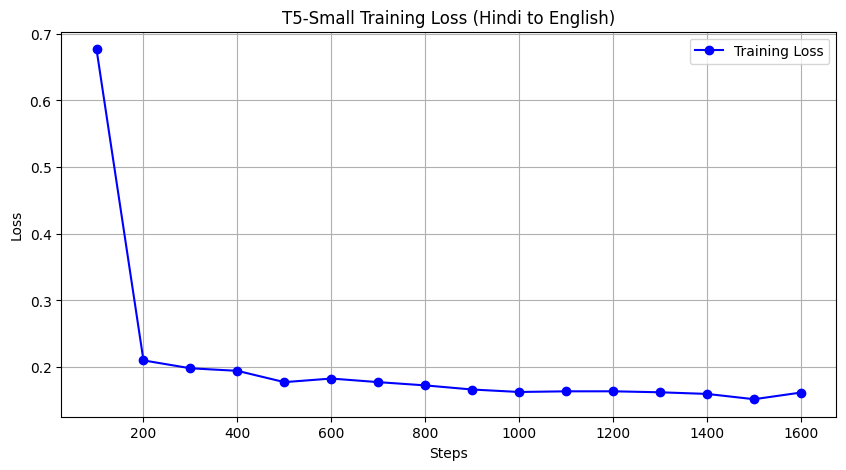


--- Process Complete! ---


In [ ]:
# ==========================================
# PHASE 3: TRAINING SETUP (Fixed for latest Trainer version)
# ==========================================
print("\nPhase 3: Starting Training...")
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",       # Ensure this is eval_strategy
    learning_rate=3e-4,
    per_device_train_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    fp16=True if torch.cuda.is_available() else False,
    logging_steps=100,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    processing_class=tokenizer,   # Changed 'tokenizer' to 'processing_class'
    data_collator=data_collator,
)

trainer.train()

# ==========================================
# PHASE 4: RESULTS VISUALIZATION
# ==========================================
print("\nPhase 4: Plotting Training Loss...")
history = trainer.state.log_history
# Filter for logs that actually contain training loss
train_loss = [x['loss'] for x in history if 'loss' in x]
steps = [x['step'] for x in history if 'loss' in x]

if train_loss:
    plt.figure(figsize=(10,5))
    plt.plot(steps, train_loss, label="Training Loss", color='blue', marker='o')
    plt.title("T5-Small Training Loss (Hindi to English)")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Training finished, but no loss logs were found. Check logging_steps.")

print("\n--- Process Complete! ---")